In [1]:
import numpy as np
from tqdm import tqdm

In [170]:

class budget_optimizer:

    def __init__(self,T,budget,params,x_position=None):
        
        self.x_position = x_position
        self.M = budget # total budget
        self.T = T      # sequence length
        self.gamma = params['gamma'] # RRA coef
        self.delta = params['delta'] # discount parameter
        self.lambd = params['lambd'] # unit cost of infomation

    @staticmethod
    # instantaneous utility function
    def utility(x, gamma):
        return x**gamma

    @staticmethod
    # first-order derivative of utility function
    def u_1st(x, gamma):
        return gamma*x**(gamma-1)

    @staticmethod
    def w_up(u,lambd):
        return np.exp(u/lambd)

    @staticmethod
    # default weight (discounting factor)
    def default_w(T,delta):
        return delta**np.arange(T+1)
    
    @staticmethod
    # affline projection
    def proj_func(budget,x):
        return x + (budget-sum(x))/len(x)
    
    @staticmethod
    def neg_adjust(x,M,neg_adjust = 1e-4):   
 
        # adjust negative x to tiny positive number
       
        if sum(x <= 0)>0:
            x_neg_adjust = (x <= 0) * neg_adjust 
            x_nonneg_adjust = (x > neg_adjust) * x - sum(x_neg_adjust) / sum(x > neg_adjust)

            x_adjust = neg_adjust + (x > neg_adjust)*x_nonneg_adjust + ((x<=neg_adjust) & (x>0))*x
        else:
            x_adjust = x

        return x_adjust / sum(x_adjust) * M
    

    def grad_func(self,x,d):

        # gradient function  
    
        u = self.utility(x,self.gamma) 
        u_prime = self.u_1st(x,self.gamma)
        
        if self.x_position is None:
            w_upper = self.w_up(u,self.lambd) * d
            w = w_upper / sum(w_upper)
        else:
            w_upper = self.w_up(u,self.lambd) * d[self.x_position]
            w_other_sum = np.delete(d, self.x_position).sum()
            w = w_upper / (sum(w_upper) + w_other_sum)

        V = w @ u
        G = w * (u+1-V) * u_prime

        obj = -np.log(V) # minimization objective
        grad = -G/V # gradient
    
        return obj, grad
    

    def solve_local(self, x_0, grad_0, obj_0, d, 
                    stepsize = 0.1, iters = 300, a_grid = np.arange(4)/3,
                    stopping = 100, tol = 1e-6):

        for i in range(iters):
            
            # Projection Gradient Descent (PG)
            y = x_0 - stepsize * grad_0
            x_1 = self.proj_func(self.M,y)

            # adjust negative x to tiny positive
            x_pg = self.neg_adjust(x_1,M=self.M)

            # new obj and grad
            obj_pg, grad_pg = self.grad_func(x_pg,d)

            # WL algorithm: concentrate all budget on the period with minimal gradient 
            y_concentrate = np.repeat(0,len(x_0))
            x_min_idx = np.where(grad_pg==min(grad_pg))[0]
            y_concentrate[x_min_idx] = self.M

            x_2 = x_pg + 2/(i+2)*(y_concentrate-x_pg)

            # adjust negative x to tiny positive
            x_wl = self.neg_adjust(x_2,M=self.M)

            # generate a series of x between PG solution and WL solution
            # calculate obj, grad for each generated x
            x_list = list(map(lambda a:x_pg * (1-a) + x_wl * a,a_grid))

            obj_list = [obj_pg]
            grad_list = [grad_pg]

            for j in range(1,len(x_list)):
                obj_wl, grad_wl = self.grad_func(x_list[j],d)
                obj_list += [obj_wl]
                grad_list += [grad_wl]


            obj_array = np.array(obj_list)
            idx_obj_min = np.where(obj_array==min(obj_array))[0]

            # if the minimal obj in the generated series of x is smaller than the old obj, then take it;
            # otherwise take the old x
            if obj_array[idx_obj_min] <= obj_0:
                grad_new = grad_list[idx_obj_min[0]]
                obj_new = obj_list[idx_obj_min[0]]
                x_new = x_list[idx_obj_min[0]]
            
            else:
                grad_new = grad_0
                obj_new = obj_0
                x_new = x_0

            # condition for early stopping
            if j > stopping:
                if abs(obj_0 - obj_new) < tol:
                    break
           
            # update x_0, obj_0, grad_0
            x_0 = x_new
            obj_0 = obj_new
            grad_0 = grad_new
        
        return x_new, grad_new, obj_new
   
        
    
    def solve(self,init_x = None,
              global_iter = 700, diffusion = 1e-3, 
              break_point = np.Inf):

        # calculate default weight (discounting factor)
        d = self.default_w(self.T,self.delta)

        # set-up initial status
        if self.x_position is None:
            init_allocation = np.repeat(1,self.T+1)
        else:
            init_allocation = np.repeat(1,len(self.x_position))
        
        if init_x is None:
            init_x = (init_allocation/sum(init_allocation))*self.M
    
        init_obj, init_grad = self.grad_func(init_x,d)

        x_0 = init_x
        grad_0 = init_grad
        obj_0 = init_obj
        self.fn = [obj_0]

        for j in tqdm(range(global_iter)):

            # local solver
            x_1, grad_1, obj_1 = self.solve_local(init_x,init_grad,init_obj,d)

            # if the new obj is smaller than the old obj, then keep the new solution
            # otherwise, take the old solution
            if obj_1 <= obj_0:
                x_new = x_1
                grad_new = grad_1
                obj_new = obj_1  
            else:
                x_new = x_0
                grad_new = grad_0
                obj_new = obj_0

            # calculate obj for the current iteration 
            self.fn += [obj_new] 

            # update x_0, obj_0, grad_0
            # x_0: add a random diffusion to x_new and ensure all are positive
            x_2 = x_new + np.random.normal(loc=0,scale=self.M*diffusion,size=len(x_new))
            init_x = self.neg_adjust(x_2,M=self.M)  
            init_obj, init_grad = self.grad_func(init_x,d)
           
            if j == break_point:
                break
            
            x_0 = x_new
            grad_0 = grad_new
            obj_0 = obj_new
        
        self.x = x_new
        self.gradient = grad_new

        return {"x":np.around(x_new, decimals=3), "obj_fn":obj_new, "gradient":grad_new}

In [173]:
delta = .9
gamma = .6
lambd = 100
T = 3
budget = 100
x_position = None
problem = budget_optimizer(T,budget,params={"delta":delta,"gamma":gamma,"lambd":lambd},x_position=x_position)
problem.solve()

100%|██████████| 700/700 [00:26<00:00, 26.48it/s]


{'x': array([38.665, 27.319, 19.668, 14.348]),
 'obj_fn': -1.9441810211282053,
 'gradient': array([-1.75538464e-02, -7.73052284e-03,  8.50944581e-05,  6.41565770e-03])}

In [179]:
delta = .9
gamma = .6
lambd = 100
T = 3
budget = 100
x_position = None
x_solve = {}
for i in range(T):
    lambd = lambd / (i+1)
    problem = budget_optimizer(T-i,budget,params={"delta":delta,"gamma":gamma,"lambd":lambd},x_position=x_position)
    problem.solve(global_iter=400)
    x_solve[i] = problem.x
    budget = budget - problem.x[0]

100%|██████████| 400/400 [00:14<00:00, 27.20it/s]


In [180]:
x_solve

{0: array([38.60554567, 27.36952998, 19.69812859, 14.32679576]),
 1: array([29.4657072 , 19.0025897 , 12.92615743]),
 2: array([26.67467519,  5.25407194])}

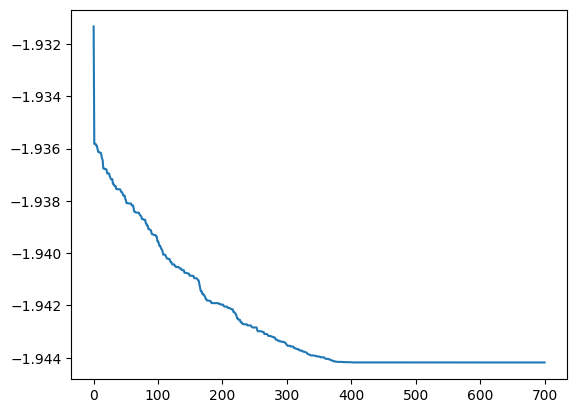

In [174]:
import matplotlib.pyplot as plt

plt.plot(problem.fn)

In [124]:
print(np.round(problem.x,3))
print(problem.fn[-1])

[100.   0.   0.   0.]
-2.7631011917412938


In [397]:
x_k = np.array([99.991,0.003,0.003,0.003])
problem.grad_func(x=x_k,d=problem.default_w(T,delta))

(-2.302423721571916,
 array([-0.00500627,  0.00035255,  0.0003173 ,  0.00028557]))